In [1]:
import os
import numpy as np
import cv2  
import pandas as pd
import random
from matplotlib import pyplot as plt

from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [2]:
df = pd.read_csv('train.csv')

target_shape = (224, 224)
def triplet_generator(df, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)
    
    all_right_images = df['right'].tolist()
    
    while True:
        samples = df.sample(n=batch_size)

        anchors = []
        positives = []
        negatives = []

        for index, row in samples.iterrows():
            anchor_img = img_to_array(load_img(f'train/left/{row["left"]}.jpg', target_size=target_shape))
            positive_img = img_to_array(load_img(f'train/right/{row["right"]}.jpg', target_size=target_shape))
            
            negative_image_name = random.choice(all_right_images)
            while negative_image_name == row['right']: 
                negative_image_name = random.choice(all_right_images)
            negative_img = img_to_array(load_img(f'train/right/{negative_image_name}.jpg', target_size=target_shape))

            anchors.append(anchor_img)
            positives.append(positive_img)
            negatives.append(negative_img)

        anchors = np.array(anchors)
        positives = np.array(positives)
        negatives = np.array(negatives)

        anchors = datagen.standardize(anchors)
        positives = datagen.standardize(positives)
        negatives = datagen.standardize(negatives)

        yield [anchors, positives, negatives], np.zeros(batch_size) 

train_df = df.sample(frac=0.8)
valid_df = df.drop(train_df.index)

train_gen = triplet_generator(train_df, batch_size=32)
valid_gen = triplet_generator(valid_df, batch_size=32)


Shape of anchors: (32, 224, 224, 3)
Shape of positives: (32, 224, 224, 3)
Shape of negatives: (32, 224, 224, 3)


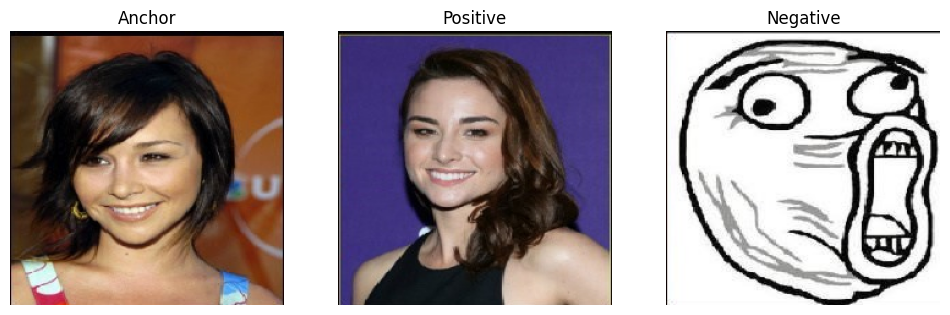

In [3]:
batch_data, batch_labels = next(train_gen)

anchors, positives, negatives = batch_data

print("Shape of anchors:", anchors.shape)
print("Shape of positives:", positives.shape)
print("Shape of negatives:", negatives.shape)



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.imshow(anchors[0])
ax1.set_title('Anchor')
ax1.axis('off')

ax2.imshow(positives[0])
ax2.set_title('Positive')
ax2.axis('off')

ax3.imshow(negatives[0])
ax3.set_title('Negative')
ax3.axis('off')

plt.show()

In [5]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
output = layers.Dense(512)(dense1)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

anchor_embedding = embedding(anchor_input)
positive_embedding = embedding(positive_input)
negative_embedding = embedding(negative_input)

output = layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=1)

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=output)

In [6]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    total_length = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:, :total_length//3], y_pred[:, total_length//3:2*total_length//3], y_pred[:, 2*total_length//3:]

    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    
    loss = tf.maximum(pos_dist - neg_dist + alpha, 0.0)
    
    return tf.reduce_mean(loss)


In [7]:
siamese_network.compile(optimizer='adam', loss=triplet_loss)
history = siamese_network.fit(train_gen, validation_data=valid_gen, epochs=9, steps_per_epoch=len(train_df) // 32, validation_steps=len(valid_df) // 32)

Epoch 1/9
50/50 [==============================] - 249s 5s/step - loss: 35.4454 - val_loss: 60.3675
Epoch 2/9
50/50 [==============================] - 246s 5s/step - loss: 2.2608 - val_loss: 3.5201
Epoch 3/9
50/50 [==============================] - 262s 5s/step - loss: 1.3546 - val_loss: 1.1152
Epoch 4/9
50/50 [==============================] - 247s 5s/step - loss: 0.8261 - val_loss: 1.0611
Epoch 5/9
50/50 [==============================] - 245s 5s/step - loss: 0.5906 - val_loss: 0.7640
Epoch 6/9
50/50 [==============================] - 237s 5s/step - loss: 0.5685 - val_loss: 0.6869
Epoch 7/9
50/50 [==============================] - 234s 5s/step - loss: 0.6574 - val_loss: 0.9660
Epoch 8/9
50/50 [==============================] - 233s 5s/step - loss: 0.6059 - val_loss: 0.8932
Epoch 9/9
50/50 [==============================] - 232s 5s/step - loss: 0.4738 - val_loss: 0.3010


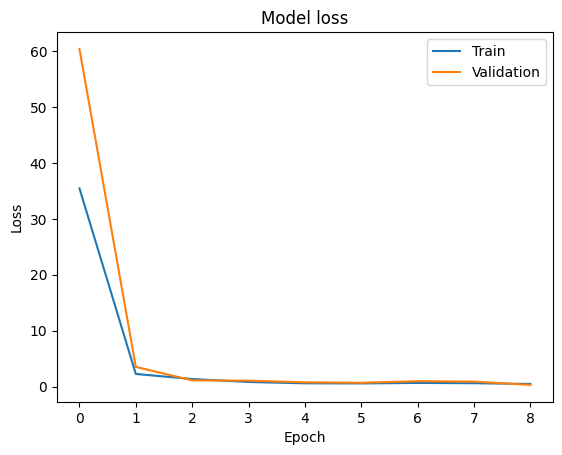

In [9]:
plt.subplot(1,1,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

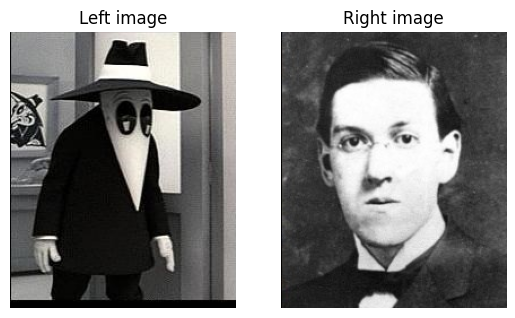

1/1 [==============================] - 0s 229ms/step
Cosine Similarity: 0.9741105139255524


In [12]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

def compute_cosine_similarity(vector_a, vector_b):
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    cosine_similarity = dot_product / (norm_a * norm_b)
    positive_similarity = (cosine_similarity + 1) / 2
    return positive_similarity

image_path_left = './train/left/afp.jpg'
image_path_right = './train/right/hve.jpg'

left_img = load_img(image_path_left)
right_img = load_img(image_path_right)
plt.subplot(1,2,1)
plt.imshow(left_img)
plt.title("Left image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(right_img)
plt.title("Right image")
plt.axis('off')
plt.show()

image_left = preprocess_image(image_path_left)
image_right = preprocess_image(image_path_right)

embedding_left = embedding.predict(image_left)
embedding_right = embedding.predict(image_right)

similarity = compute_cosine_similarity(embedding_left[0], embedding_right[0])
print(f"Cosine Similarity: {similarity}")




In [11]:
df = pd.read_csv('test_candidates.csv')

left_image_dir = './test/left/'
right_image_dir = './test/right/'

for idx, row in df.iloc[250:500].iterrows():
    # Load the left image
    left_image_name = row['left']
    left_image_path = left_image_dir + left_image_name + '.jpg'  
    left_image = preprocess_image(left_image_path)
    left_embedding = embedding.predict(left_image)
    for col in df.columns[1:]: 
        right_image_name = row[col]
        right_image_path = right_image_dir + right_image_name + '.jpg'
        right_image = preprocess_image(right_image_path)
        right_embedding = embedding.predict(right_image)
        
        similarity = compute_cosine_similarity(left_embedding[0], right_embedding[0])
        df.at[idx, col] = similarity  

df.to_csv('test_similarity_scores2.csv', index=False)

1/1 [==============================] - 0s 243ms/step
